In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=6e8a4025442776ec2983c9487f9f160a1a96c226ba341a63c97c341c9ed795f1
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [21]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
import lime
import lime.lime_tabular
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.inspection import PartialDependenceDisplay

df = pd.read_csv('Phishing Websites Engineered.csv')

In [5]:
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Model training

In [6]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)


GradientBoostingClassifier(random_state=42)

In [8]:
y_pred = gb_model.predict(X_test)

In [9]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

print("Gradient Boosting Results (All Features):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Gradient Boosting Results (All Features):
Accuracy: 0.9402
Precision: 0.9291
Recall: 0.9488
F1 Score: 0.9388


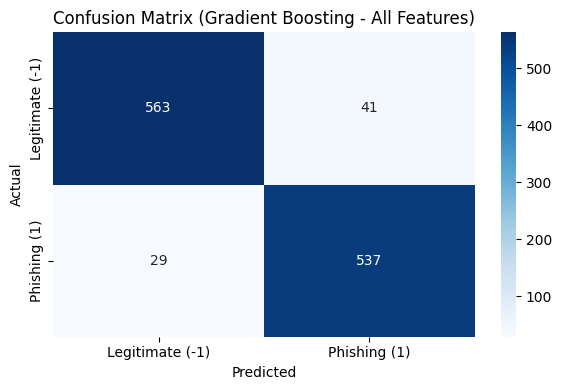

In [10]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate (-1)', 'Phishing (1)'], yticklabels=['Legitimate (-1)', 'Phishing (1)'])
plt.title('Confusion Matrix (Gradient Boosting - All Features)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Interpretability Technique

## Feature Importance via Gradient Boosting

In [11]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 5 Important Features:\n", feature_importance.head())

Top 5 Important Features:
              Feature  Importance
7     sslfinal_state    0.695329
13     url_of_anchor    0.143751
5      prefix_suffix    0.040040
30  total_link_flags    0.039703
25       web_traffic    0.018673


## SHAP

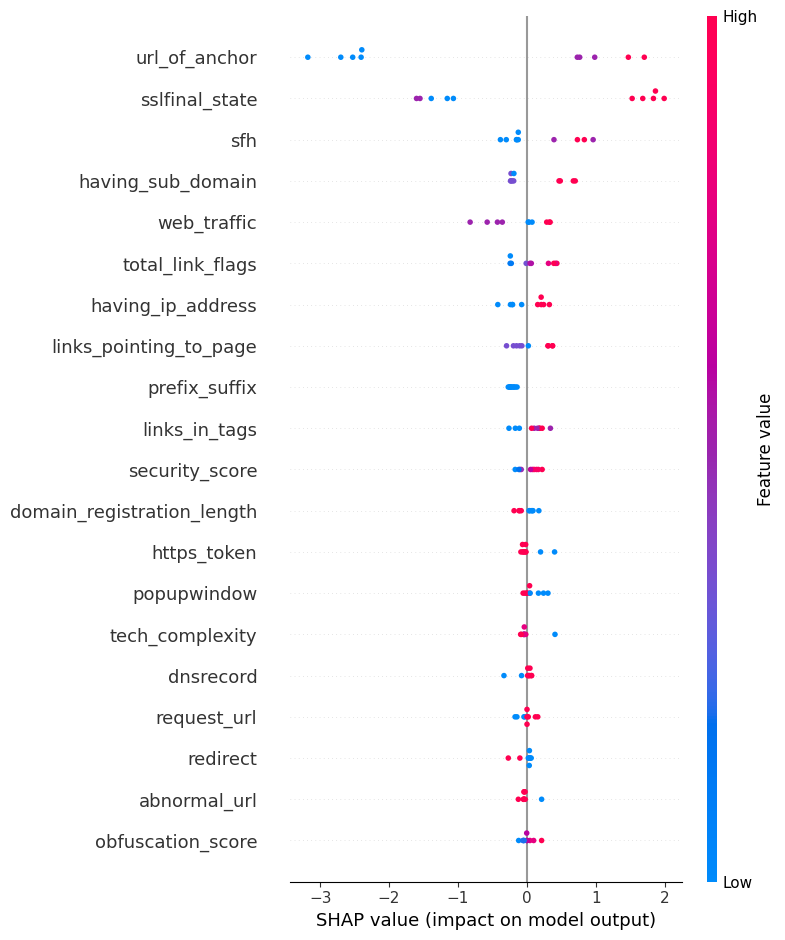

In [12]:
background = shap.sample(X_train, 100, random_state=42)
gb_explainer = shap.TreeExplainer(gb_model)

sample = X_test.sample(10, random_state=42)

gb_shap_values = gb_explainer.shap_values(sample)

shap.summary_plot(gb_shap_values, sample, feature_names=sample.columns)

## LIME

In [17]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns.tolist(),
    class_names=['Legitimate', 'Phishing'],
    mode='classification'
)


In [18]:
def explain_instance_lime(model, model_name):
    i = np.random.randint(0, X_test.shape[0])
    exp = lime_explainer.explain_instance(
        X_test.iloc[i],
        model.predict_proba,
        num_features=10
    )
    print(f"\n🔍 LIME Explanation for model: {model_name} on instance {i}")
    exp.show_in_notebook(show_table=True)
    return exp

In [19]:
# Explain one instance with each model
explain_instance_lime(gb_model, "Gradient Boosting")


🔍 LIME Explanation for model: Gradient Boosting on instance 746


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

# PDP & ICE

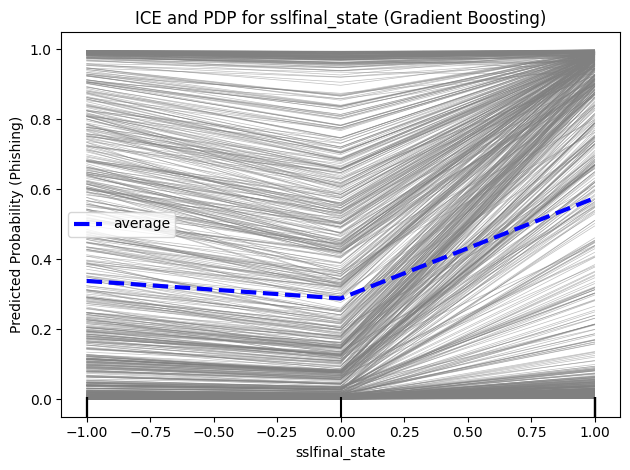

In [27]:
top_feature = feature_importance.iloc[0]['Feature']

display = PartialDependenceDisplay.from_estimator(
    gb_model,
    X_test,
    features=[top_feature],
    kind='both',
    ice_lines_kw={'color': 'gray', 'alpha': 0.5},
    pd_line_kw={'color': 'blue', 'linewidth': 3}
)
plt.title(f"ICE and PDP for {top_feature} (Gradient Boosting)")
plt.xlabel(top_feature)
plt.ylabel("Predicted Probability (Phishing)")
plt.tight_layout()
plt.show()